In [1]:
!which python; python --version

/Users/swagatam/miniconda3/envs/vexl/bin/python
Python 3.8.18


## Provided functions

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def cost_fn(w, x, y, lmbd):
    ''' L1 loss + L2 regularization

    w: weights to estimate d
    x: data points n x d
    y: true values n x 1
    lmbd: weight regularization

    output: loss ||x * w - y||_1 + lmbd * ||w||_2^2
    '''
    return np.abs(x @ np.expand_dims(w, 1) - y).sum() +\
           lmbd * (w ** 2).sum()

def L1LossRegression(X, Y, lmbd_reg=0.):
    ''' solves linear regression with
    L1 Loss + L2 regularization

    X: deisgn matrix n x d
    Y: true values n x 1
    lmbd_reg: weight regularization

    output: weight of linear regression d x 1
    '''
    w = minimize(cost_fn, np.zeros(X.shape[1]),
                 args=(X, Y, lmbd_reg)).x
    return np.expand_dims(w, 1)

In [3]:
def LeastSquares(Designmatrix, Y):
    ''' solves least squares linear regression.
    
    Designmatrix: feature matrix n x d
    Y: labels n x 1
    
    returns: learned weights w d x 1
    '''
    A = Designmatrix.T @ Designmatrix
    b = Y
    # solve for Ax=b
    w = np.linalg.solve(A, b)
    assert np.allclose(w, np.linalg.inv(A) @ b), "some error in equation solver"
    return w
    
def RidgeRegression(Designmatrix, Y, Lambda):
    ''' solves ridge regression (l2 regularization).
    
    Designmatrix: feature matrix n x d
    Y: labels n x 1
    
    returns: learned weights w d x 1
    '''
    A = Designmatrix.T @ Designmatrix
    LambdaId = Lambda * np.eye(Designmatrix.shape[1])
    
    # note that (A + LambdaId) is also symmetric pos def, so unique solution always exists as invertible
    w = np.linalg.solve(A + LambdaId, (Designmatrix.T@Y))
    assert np.allclose(w, np.linalg.inv(A + LambdaId) @ (Designmatrix.T@Y)), "some error in equation solver"
    return w

## Basis function

In [4]:
def phi0(x):
    return np.ones_like(x)

def phi_2l_minus_1(x, l):
    return np.cos(2*np.pi*l*x)

def phi_2l(x, l):
    return np.sin(2*np.pi*l*x)

def Basis(X, k):
    ''' generate the design matrix using the orthogonal Fourier basis functions
    X: n x 1 feature vector
    k: maximal frequency
    
    output: Designmatrix of shape n x (2k+1)
    so each scalar observation is now a 2k+1 sized feature vector.
    '''
    # l runs from 1,2,...,k
    features = [phi0(X)]
    for l in range(1,k+1):
        features.append(phi_2l_minus_1(X, l))
        features.append(phi_2l(X, l))
    return np.column_stack(features)

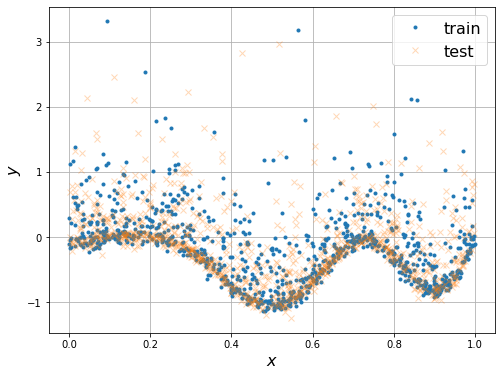

In [5]:
data = np.load('./onedim_data.npy', allow_pickle=True).item()
Xtrain, Ytrain, Xtest, Ytest = data['Xtrain'], data['Ytrain'], data['Xtest'], data['Ytest']


plt.figure(figsize=(8,6))
plt.plot(Xtrain, Ytrain, '.', label='train')
plt.plot(Xtest, Ytest, 'x', alpha=0.3, label='test')
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$y$', fontsize=16)
plt.grid()
plt.legend(fontsize=16)

plt.show()

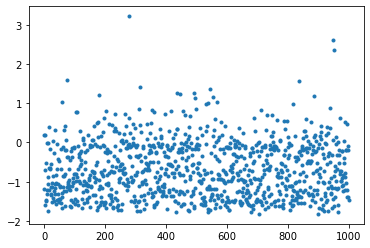

In [6]:
# see the residual distribution
plt.plot(Ytrain - Xtrain, '.')

L1 loss --- mae loss, robust to outliers, penalizes all data points equallu
L2 loss --- mse loss, penalizes outliers heavily

also looks like the noise is mostly positive, and NOT distributed in a gaussian way!

So we will take "L1 loss" for this regression problem.

In [17]:
def L1loss(w, x, y, lmbd):
    return np.abs(x@w - y).sum() + lmbd * (w**2).sum()

In [18]:
USE_LOSS = {
    "L1": L1LossRegression,
    "L2": RidgeRegression,
}

In [19]:
LOSSS = 'L1'

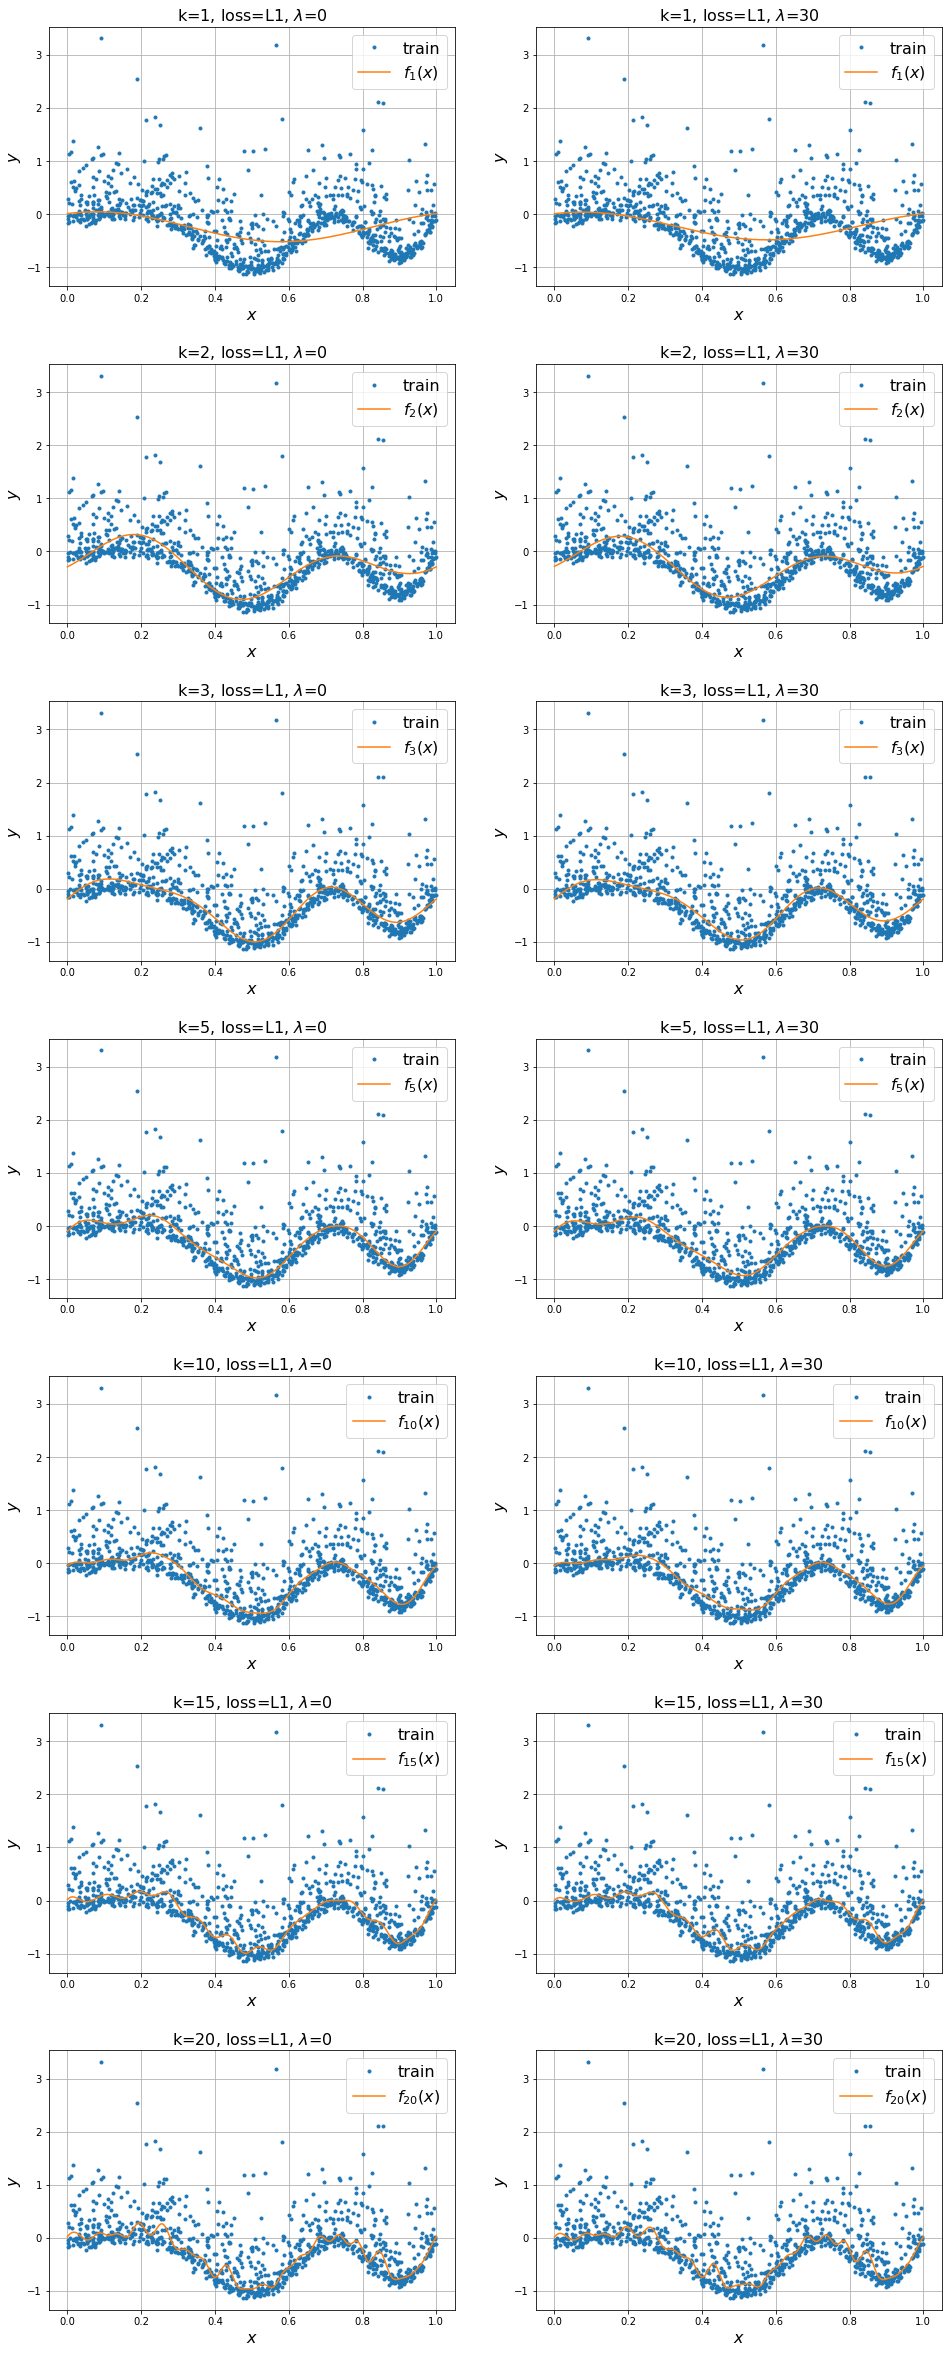

In [20]:
K = [1,2,3,5,10,15,20]
LAMBDA = [0, 30]#, 1000]

nrows = len(K)
ncols = len(LAMBDA)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(8*ncols, 6*nrows),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})
train_losses = {}
test_losses = {}


for i, k in enumerate(K):
    train_losses[k] = {}
    test_losses[k] = {}
    for j, lmda in enumerate(LAMBDA):
        
        # print(f'k: {k}, lmda: {lmda}')
        x = np.linspace(0, 1, 1000)
        w = L1LossRegression(X=Basis(Xtrain, k), Y=Ytrain, lmbd_reg=lmda)
        # print(w)
        # print(w.shape)
        y_pred = Basis(x, k) @ w
        
        train_losses[k][lmda] = L1loss(w, Basis(Xtrain,k), Ytrain, lmda)
        test_losses[k][lmda] = L1loss(w, Basis(Xtest,k), Ytest, lmda)
        
        ax = axes[i, j]
        ax.plot(Xtrain, Ytrain, '.', label='train')
        ax.plot(x, y_pred, label=fr'$f_{{{k}}}(x)$')
        # plt.plot(Xtest, Ytest, 'x', alpha=0.3, label='test')
        ax.set_xlabel(r'$x$', fontsize=16)
        ax.set_ylabel(r'$y$', fontsize=16)
        ax.grid()
        ax.legend(fontsize=16)
        ax.set_title(fr'k={k}, loss={LOSSS}, $\lambda$={lmda}', fontsize=16)

plt.show()

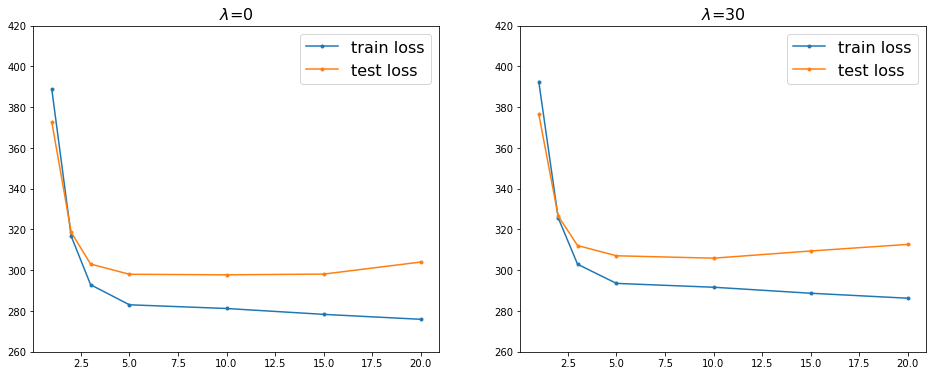

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(8*2, 6),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})

for i, lmda in enumerate(LAMBDA):
    trnlosses = [train_losses[k][lmda] for k in K]
    tstlosses = [test_losses[k][lmda] for k in K]
    
    axes[i].plot(K, trnlosses, '.-', label='train loss')
    axes[i].plot(K, tstlosses, '.-', label='test loss')
    axes[i].legend(fontsize=16)
    axes[i].set_title(fr"$\lambda$={lmda}", fontsize=16)
    axes[i].set_ylim(260, 420)
    
plt.show()

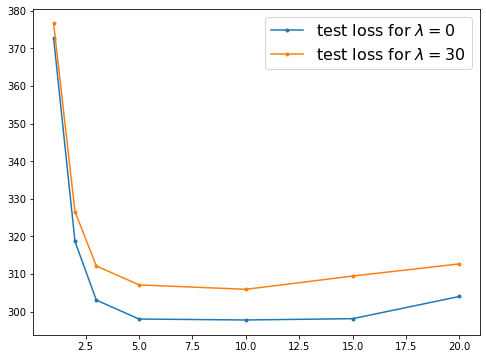

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(8, 6),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})

for lmda in LAMBDA:
    trnlosses = [train_losses[k][lmda] for k in K]
    tstlosses = [test_losses[k][lmda] for k in K]
    
    axes.plot(K, tstlosses, '.-', label=fr'test loss for $\lambda={lmda}$')
    axes.legend(fontsize=16)
    
plt.show()

In [23]:
trnlosses, tstlosses

([392.5916948061101,
  325.77635732037743,
  302.94761848113336,
  293.56044271610546,
  291.67355482879526,
  288.73213408815263,
  286.2899536892739],
 [376.6373115189948,
  326.59660043380796,
  312.13709798586484,
  307.10481112971206,
  305.9276429339541,
  309.45369921368456,
  312.68737174582037])

In [24]:
train_losses

{1: {0: 388.8318148187591, 30: 392.5916948061101},
 2: {0: 316.7373829171048, 30: 325.77635732037743},
 3: {0: 292.89931678673173, 30: 302.94761848113336},
 5: {0: 283.0603659419887, 30: 293.56044271610546},
 10: {0: 281.2439303542287, 30: 291.67355482879526},
 15: {0: 278.366146362834, 30: 288.73213408815263},
 20: {0: 275.9454258266542, 30: 286.2899536892739}}

## try with l2 loss

In [151]:
# for k in K:
#     x = np.linspace(0, 1, 1000)
#     # w = L1LossRegression(X=Basis(Xtrain, k), Y=Ytrain, lmbd_reg=lmda)
#     w = RidgeRegression(Designmatrix=Basis(Xtrain, k), Y=Ytrain, Lambda=lmda)
#     # print(w)
#     y_pred = Basis(x, k) @ w
    
#     plt.figure(figsize=(8,6))
#     plt.plot(Xtrain, Ytrain, '.', label='train')
#     plt.plot(x, y_pred, label=fr'$f_{{{k}}}(x)$')
#     # plt.plot(Xtest, Ytest, 'x', alpha=0.3, label='test')
#     plt.xlabel(r'$x$', fontsize=16)
#     plt.ylabel(r'$y$', fontsize=16)
#     plt.grid()
#     plt.legend(fontsize=16)

#     plt.show()
    
    
    
# #     break

In [136]:
# Basis(x, k) @ w

In [137]:
# w

# Normalized basis
$\phi_{2\ell-1} = \cos 2\pi\ell x $:
$$
\begin{align}
\Omega(\phi_{2\ell-1}) &= \int_{0}^{1} |\phi_{2\ell-1}'(x)| dx \\
&= \int_{0}^{1} |-2\pi\ell\sin 2\pi\ell x| dx \\
&= 4\pi^2\ell^2\int_{0}^{1} \sin^2 2\pi\ell x dx \\
&= 2\pi^2\ell^2\int_{0}^{1} 2 \sin^2 2\pi\ell x dx \\
&= 2\pi^2\ell^2\int_{0}^{1} (1 - \cos 4\pi\ell x) dx \\
&= 2\pi^2\ell^2 (1 - 0) \\
&= 2\pi^2\ell^2\\
\end{align}
$$

Similarly for $\phi_{2\ell} = \sin 2\pi\ell x $:
$$
\begin{align}
\Omega(\phi_{2\ell}) &= 4\pi^2\ell^2\int_{0}^{1} \cos^2 2\pi\ell x dx \\
&= 2\pi^2\ell^2\int_{0}^{1} 2 \cos^2 2\pi\ell x dx \\
&= 2\pi^2\ell^2\int_{0}^{1} (1 + \cos 4\pi\ell x) dx \\
&= 2\pi^2\ell^2 (1 + 0) \\
&= 2\pi^2\ell^2\\
\end{align}
$$

In [25]:
def psi0(x):
    return phi0(x)

def psi_2l_minus_1(x, l):
    return phi_2l_minus_1(x,l) / np.sqrt(2 * np.pi**2 * l**2)

def psi_2l(x, l):
    return phi_2l(x,l) / np.sqrt(2 * np.pi**2 * l**2)

def FourierBasisNormalized(X, k):
        # l runs from 1,2,...,k
    features = [psi0(X)]
    for l in range(1,k+1):
        features.append(psi_2l_minus_1(X, l))
        features.append(psi_2l(X, l))
    return np.column_stack(features)

In [ ]:
LOSSS = 'L1'

(3, 1)
(3, 1)
(5, 1)
(5, 1)
(7, 1)
(7, 1)
(11, 1)
(11, 1)
(21, 1)
(21, 1)
(31, 1)
(31, 1)
(41, 1)
(41, 1)


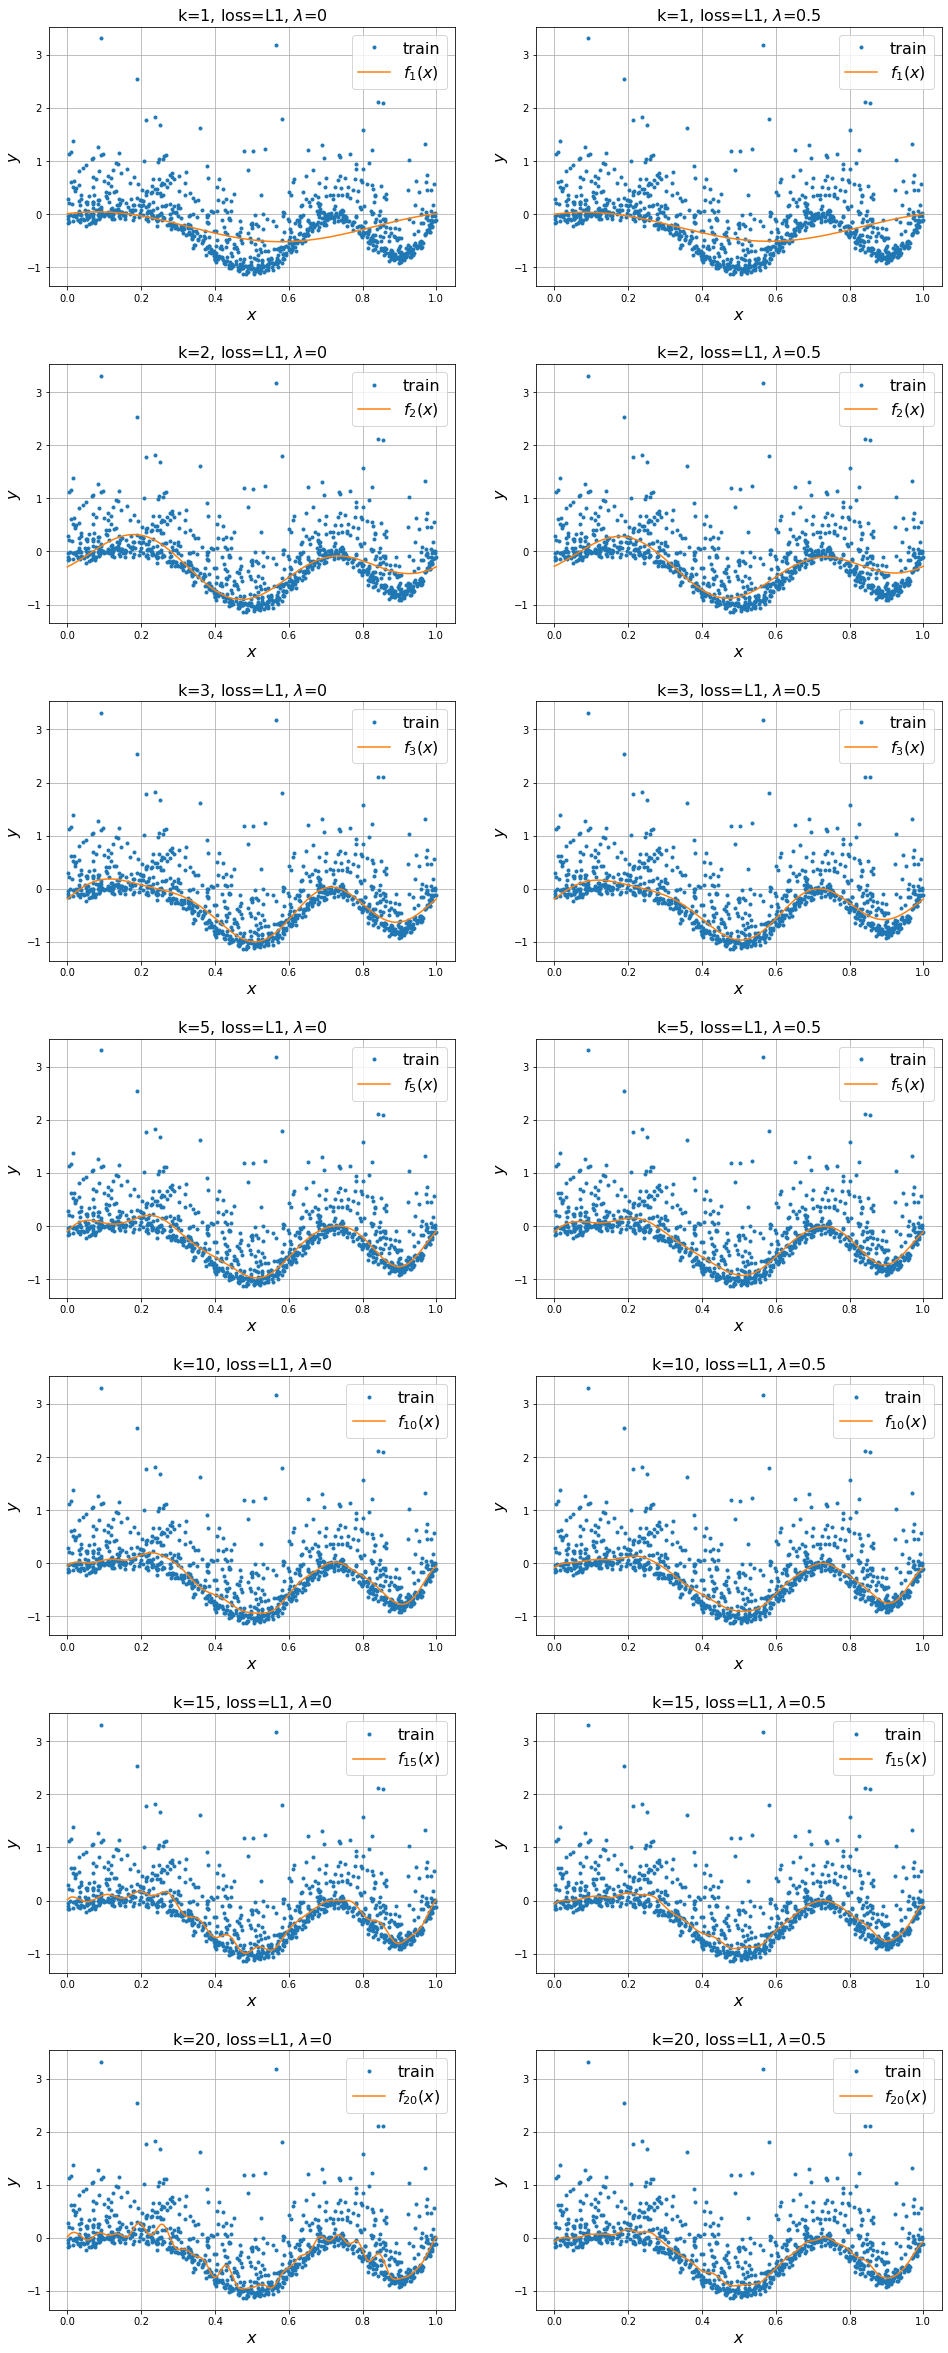

In [26]:
K = [1,2,3,5,10,15,20]
LAMBDA = [0, 0.5]#, 30]#, 100]

nrows = len(K)
ncols = len(LAMBDA)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(8*ncols, 6*nrows),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})
train_losses = {}
test_losses = {}


for i, k in enumerate(K):
    train_losses[k] = {}
    test_losses[k] = {}
    for j, lmda in enumerate(LAMBDA):
        
        # print(f'k: {k}, lmda: {lmda}')
        x = np.linspace(0, 1, 1000)
        w = L1LossRegression(X=FourierBasisNormalized(Xtrain, k), Y=Ytrain, lmbd_reg=lmda)
        # w = RidgeRegression(Designmatrix=Basis(Xtrain, k), Y=Ytrain, Lambda=lmda)
        # print(w)
        print(w.shape)
        y_pred = FourierBasisNormalized(x, k) @ w
        
        train_losses[k][lmda] = L1loss(w, FourierBasisNormalized(Xtrain,k), Ytrain, lmda)
        test_losses[k][lmda] = L1loss(w, FourierBasisNormalized(Xtest,k), Ytest, lmda)
        
        ax = axes[i, j]
        ax.plot(Xtrain, Ytrain, '.', label='train')
        ax.plot(x, y_pred, label=fr'$f_{{{k}}}(x)$')
        # plt.plot(Xtest, Ytest, 'x', alpha=0.3, label='test')
        ax.set_xlabel(r'$x$', fontsize=16)
        ax.set_ylabel(r'$y$', fontsize=16)
        ax.grid()
        ax.legend(fontsize=16)
        ax.set_title(fr'k={k}, loss={LOSSS}, $\lambda$={lmda}', fontsize=16)

plt.show()

In [27]:
# train_losses

In [28]:
# test_losses

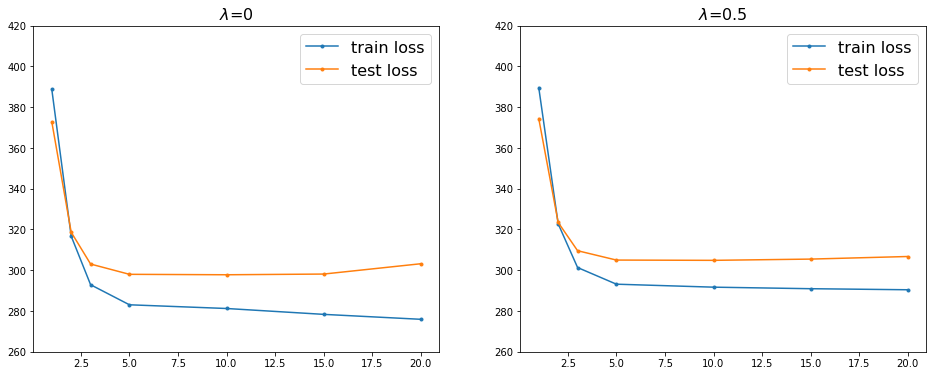

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(8*2, 6),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})

for i, lmda in enumerate(LAMBDA):
    trnlosses = [train_losses[k][lmda] for k in K]
    tstlosses = [test_losses[k][lmda] for k in K]
    
    axes[i].plot(K, trnlosses, '.-', label='train loss')
    axes[i].plot(K, tstlosses, '.-', label='test loss')
    axes[i].legend(fontsize=16)
    axes[i].set_title(fr"$\lambda$={lmda}", fontsize=16)
    axes[i].set_ylim(260, 420)
    
plt.show()

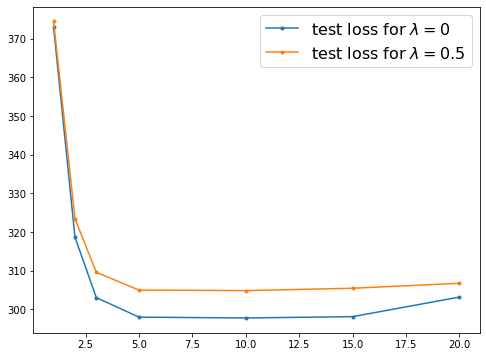

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(8, 6),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})

for lmda in LAMBDA:
    trnlosses = [train_losses[k][lmda] for k in K]
    tstlosses = [test_losses[k][lmda] for k in K]
    
    axes.plot(K, tstlosses, '.-', label=fr'test loss for $\lambda={lmda}$')
    axes.legend(fontsize=16)
    
plt.show()

## Normalized basis --- Ridge Regression

In [31]:
def L2loss(w, x, y, lmbd):
    return ((x@w - y)**2).sum() + lmbd * (w**2).sum()

LOSSS='L2'

(3, 1)
(3, 1)
(5, 1)
(5, 1)
(7, 1)
(7, 1)
(11, 1)
(11, 1)
(21, 1)
(21, 1)
(31, 1)
(31, 1)
(41, 1)
(41, 1)


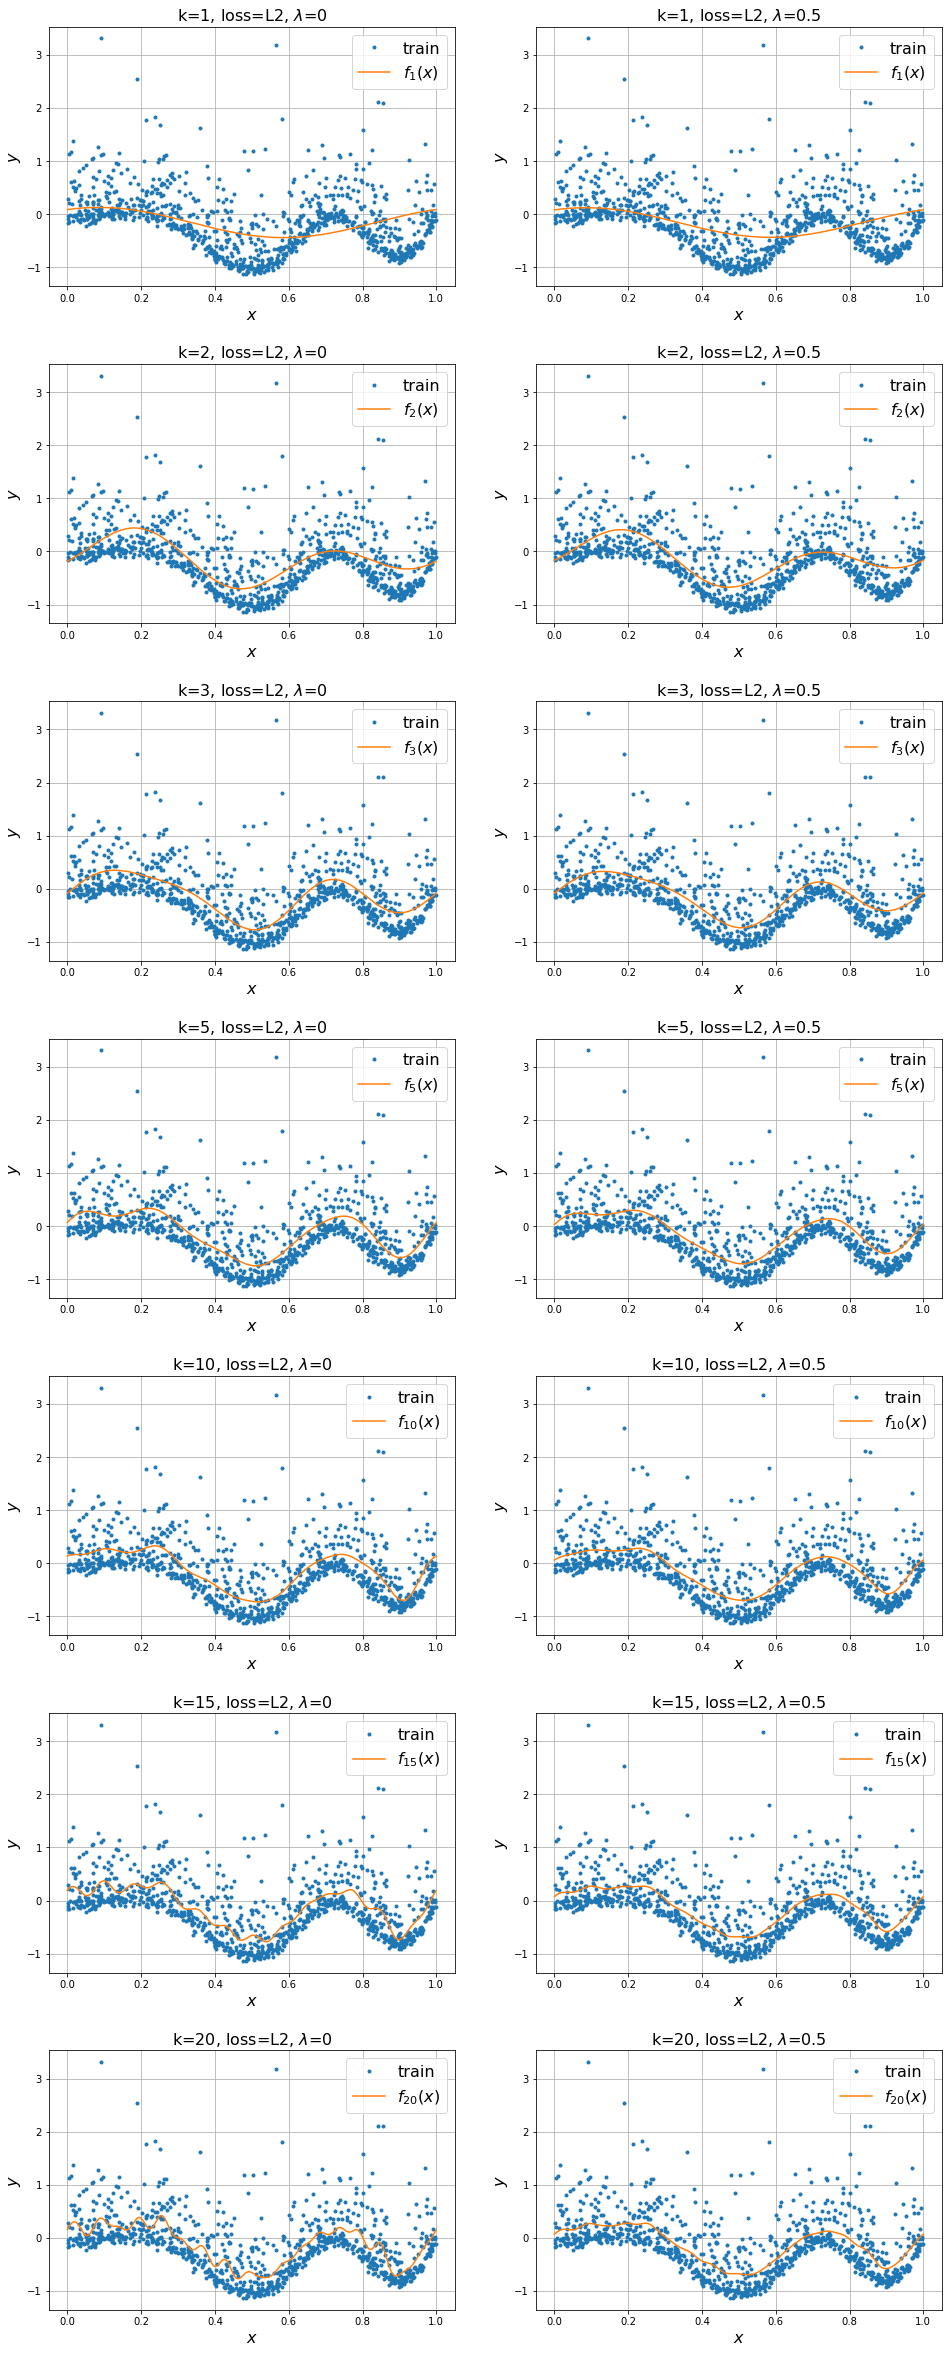

In [32]:
K = [1,2,3,5,10,15,20]
LAMBDA = [0, 0.5]#, 30]#, 100]

nrows = len(K)
ncols = len(LAMBDA)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(8*ncols, 6*nrows),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})
train_losses = {}
test_losses = {}


for i, k in enumerate(K):
    train_losses[k] = {}
    test_losses[k] = {}
    for j, lmda in enumerate(LAMBDA):
        
        # print(f'k: {k}, lmda: {lmda}')
        x = np.linspace(0, 1, 1000)
        # w = L1LossRegression(X=FourierBasisNormalized(Xtrain, k), Y=Ytrain, lmbd_reg=lmda)
        w = RidgeRegression(Designmatrix=FourierBasisNormalized(Xtrain, k), Y=Ytrain, Lambda=lmda)
        # print(w)
        print(w.shape)
        y_pred = FourierBasisNormalized(x, k) @ w
        
        train_losses[k][lmda] = L2loss(w, FourierBasisNormalized(Xtrain,k), Ytrain, lmda)
        test_losses[k][lmda] = L2loss(w, FourierBasisNormalized(Xtest,k), Ytest, lmda)
        
        ax = axes[i, j]
        ax.plot(Xtrain, Ytrain, '.', label='train')
        ax.plot(x, y_pred, label=fr'$f_{{{k}}}(x)$')
        # plt.plot(Xtest, Ytest, 'x', alpha=0.3, label='test')
        ax.set_xlabel(r'$x$', fontsize=16)
        ax.set_ylabel(r'$y$', fontsize=16)
        ax.grid()
        ax.legend(fontsize=16)
        ax.set_title(fr'k={k}, loss={LOSSS}, $\lambda$={lmda}', fontsize=16)

plt.show()

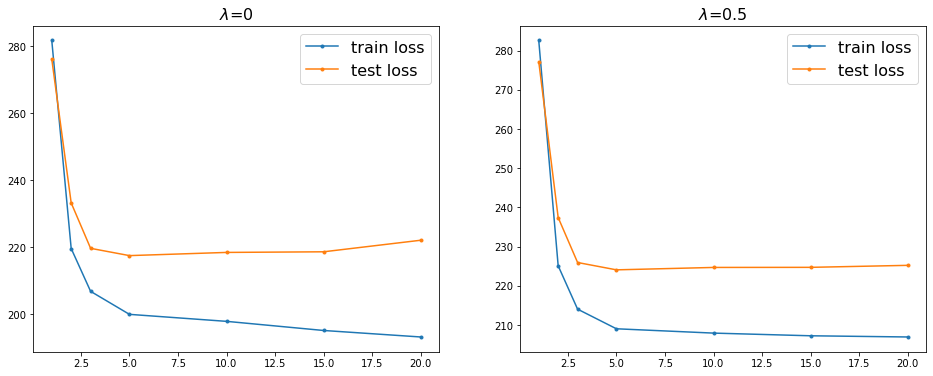

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(8*2, 6),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})

for i, lmda in enumerate(LAMBDA):
    trnlosses = [train_losses[k][lmda] for k in K]
    tstlosses = [test_losses[k][lmda] for k in K]
    
    axes[i].plot(K, trnlosses, '.-', label='train loss')
    axes[i].plot(K, tstlosses, '.-', label='test loss')
    axes[i].legend(fontsize=16)
    axes[i].set_title(fr"$\lambda$={lmda}", fontsize=16)
#     axes[i].set_ylim(260, 420)
    
plt.show()

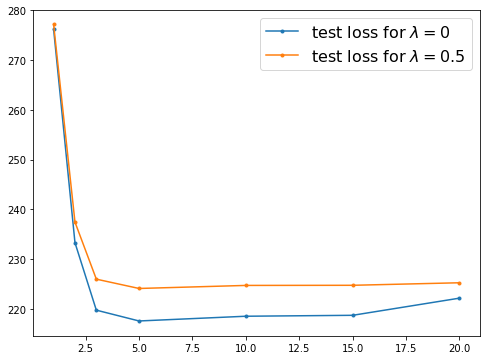

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(8, 6),
                         gridspec_kw={'wspace':0.2,'hspace':0.3})

for lmda in LAMBDA:
    trnlosses = [train_losses[k][lmda] for k in K]
    tstlosses = [test_losses[k][lmda] for k in K]
    
    axes.plot(K, tstlosses, '.-', label=fr'test loss for $\lambda={lmda}$')
    axes.legend(fontsize=16)
    
plt.show()

## Exercise 2 -- LASSO

- $||y-x||^2$ is strictly convex function for y (hessian I p.d), hence unique minimizer
- projection onto orthant: $y_i = max\{0, x_i\}$

In [4]:
lmbd = 10
data_new = np.load('multidim_data.npy', allow_pickle=True).item()
X, Y = data_new['Xtrain'], data_new['Ytrain']
Xval, Yval = data_new['Xtest'], data_new['Ytest']

EX, StdX = X.mean(0), X.std(0)

X = (X - EX) / StdX
Xval = (Xval - EX) / StdX

X = np.c_[np.ones((X.shape[0],1)), X]
Xval = np.c_[np.ones((Xval.shape[0],1)), Xval]

In [5]:
X.shape, Y.shape, Xval.shape, Yval.shape

((1500, 101), (1500, 1), (402, 101), (402, 1))

In [6]:
def L2Loss(x, y):
    return (x - y) ** 2

def LassoObjective(wplus, wminus, Phi, Y, lmbd):
    ''' evaluates the objective function at (wplus, wminus)
    L2 loss + L1 regularization
    '''
    w = wplus - wminus
    return ((Phi @ w - Y) ** 2).mean(
        ) + lmbd * np.abs(w).sum()

In [7]:
def GradLassoObjective(wplus, wminus, Phi, Y, lmbd):
    ''' computes the gradients of the objective function
    at (wplus, wminus)
    gradwplus: gradient wrt wplus
    gradwminus: gradient wrt minus

    FILL IN
    '''

    #gradwplus = np.zeros(wplus.shape)    # TODO 
    #gradwminus = np.zeros(wminus.shape)  # TODO
    
    n = Phi.shape[0]
    gradwplus = (2/n) * ((Phi.T@Phi) @ (wplus-wminus) - Phi.T@Y) + lmbd*np.sign(wplus)
    gradwminus = (2/n) * ((Phi.T@Phi) @ (wminus-wplus) + Phi.T@Y) + lmbd*np.sign(wminus)
    
    return gradwplus, gradwminus

def ProjectionPositiveOrthant(x):
    ''' returns the projection of x onto the positive orthant

    FILL IN
    '''
    y = x # TODO 
    negidx = y < 0
    y[negidx] = 0
    return y

def getStepSize(wplus, wminus, Phi, Y, lmbd, gradwplus,
                gradwminus, loss):
    ''' performs one step of projected gradient descent (i.e.
    compute next iterate) with step size selection via
    backtracking line search

    input
    loss: objective function at current iterate (wplus, wminus)

    output
    wplusnew, wminusnew: next iterates wplus_{t+1}, wminus_{t+1}
    lossnew: objective function at the new iterate
    
    FILL IN
    '''
    alpha, beta, sigma = 1., .01, .1
    wplusnew, wminusnew = wplus.copy(), wminus.copy()
    lossnew = np.float64('Inf') # make sure to enter the loop

    # choose the step size alpha with backtracking line search
    while lossnew > loss + sigma * ((gradwplus * (
        wplusnew - wplus)).sum() + (gradwminus * (
        wminusnew - wminus)).sum()):
        # get new step size to test
        alpha *= beta

        # projected gradient step for wplus and wminus with step size alpha
        # i.e. compute x_{t+1} as in the text
        # FILL IN
        # print('fill in with projected gradient step')
        wplusnew = ProjectionPositiveOrthant(wplus - alpha * gradwplus)    # TODO 
        wminusnew = ProjectionPositiveOrthant(wminus - alpha * gradwminus)  # TODO

        # compute new value of the objective
        lossnew = LassoObjective(wplusnew, wminusnew, Phi, Y, lmbd)

    return wplusnew, wminusnew, lossnew

In [8]:
ProjectionPositiveOrthant(np.random.randn(10))

array([0.44917603, 0.17267584, 0.22652786, 0.2468242 , 0.54010695,
       0.        , 0.09693844, 0.        , 0.24111009, 0.        ])

In [10]:
def Lasso(Phi, Y, lmbd):
    ''' compute weight of linear regression with Lasso

    Phi: deisgn matrix n x d
    Y: true values n x 1
    lmbd: weight of regularization

    output: weights of linear regression d x 1
    '''
    # initialize wplus, wminus
    wplus = np.random.rand(Phi.shape[1], 1)
    wminus = np.random.rand(*wplus.shape)
    loss = LassoObjective(wplus, wminus, Phi, Y, lmbd)

    counter = 1
    while counter > 0:
        # compute gradients wrt wplus and wminus
        gradwplus, gradwminus = GradLassoObjective(
            wplus, wminus, Phi, Y, lmbd)

        # compute new iterates
        wplus, wminus, loss = getStepSize(wplus,
            wminus, Phi, Y, lmbd, gradwplus, gradwminus, loss)

        if (counter % 10000) == 0:
            # check if stopping criterion is met
            wnew = wplus - wminus
            ind = wnew != 0.
            indz = wnew == 0.
            r = 2 / Phi.shape[0] * (Phi.T @ (Phi @ wnew - Y))
            stop = np.abs(r[ind] + lmbd * np.sign(wnew[ind]
                )).sum() + (np.abs(r[indz]) - lmbd * np.ones_like(
                r[indz])).clip(0.).sum()
            print('iter={} current objective={:.3f} nonzero weights={}'.format(
                counter, loss, ind.sum()) +\
                ' stop={:.5f}'.format(stop / Phi.shape[0]))
            if np.abs(stop) / Phi.shape[0] < 1e-5:
                break
        counter += 1

    #print((wplus == 0).sum(), (wminus == 0).sum())

    return wplus - wminus

In [11]:
t_init = time.time()
w = Lasso(X, Y, lmbd)
print('runtime: {:.3f} s'.format(time.time() - t_init))

iter=10000 current objective=141361.364 nonzero weights=42 stop=0.00131
iter=20000 current objective=141345.840 nonzero weights=41 stop=0.00013
iter=30000 current objective=141345.807 nonzero weights=41 stop=0.00001
runtime: 32.381 s


training loss: 125093.05681
validation loss: 200281.10508


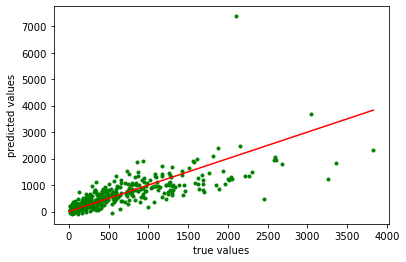

In [12]:
LossTrain = L2Loss(X @ w, Y)
print('training loss: {:.5f}'.format(LossTrain.mean()))
Yvalpred = Xval @ w # TODO, compute predictions
LossVal = L2Loss(Yvalpred, Yval)
print('validation loss: {:.5f}'.format(LossVal.mean()))
plt.plot(Yval, Yvalpred, '.g')
plt.plot([0, np.amax(Yval)], [0, np.amax(Yval)], '-r')
ax = plt.gca()
ax.set_xlabel('true values')
ax.set_ylabel('predicted values')
plt.show()